In [1]:
import os
import requests
import pandas as pd
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.stats import gamma
from scipy.optimize import minimize
from scipy.interpolate import RectBivariateSpline
import emcee
import corner
import scipy.io as sio
from ipywidgets import FloatProgress
from IPython.display import display
import time
import os.path
from os import path

import sys
sys.path.insert(0, '..')
import dr25Models as funcModels

In [2]:
def medianAndErrorbars(data):
    if data.ndim > 1:
        dataResult = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(data, [16, 50, 84],
                                                axis=0)))
        dataResult = list(dataResult)
        return dataResult
    else:
        v = np.percentile(data, [16, 50, 84])
        return [v[1], v[2]-v[1], v[1]-v[0]]


def printMedianAndErrorbars(data):
    e = medianAndErrorbars(data)
    if data.ndim > 1:
        print("printMedianAndErrorbars only works for 1D arrays")
    else:
        return "{:.3f}".format(e[0]) +"^{+" + "{:.3f}".format(e[1]) + "}_{-" + "{:.3f}".format(e[2]) + "}"



In [3]:
def compute_deltas(d, base):
    delta = np.zeros(d.shape)
    delta[0] = d[0]-baselineZeta[0]
    if d[0] > baselineZeta[0]:
        # i > j, so use i minus and j plus
        delta[1] = np.sqrt(d[2]**2 + baselineZeta[1]**2)
    else:
        # i <= j, so use i plus and j minus
        delta[1] = np.sqrt(d[1]**2 + baselineZeta[2]**2)
    if delta[1] > 0:
        delta[2] = delta[0]/delta[1]
    return delta;

def compute_separation(medianVec, sigmaVecPlus, sigmaVecMinus):
    separation = np.zeros((len(medianVec), len(medianVec)))
    separationSigma = np.zeros((len(medianVec), len(medianVec)))
    separationInSigma = np.zeros((len(medianVec), len(medianVec)))
    for i in range(len(medianVec)):
        for j in range(i):
            separation[i,j] = np.abs(medianVec[i]-medianVec[j])
            if medianVec[i] > medianVec[j]:
                # i > j, so use i minus and j plus
                separationSigma[i,j] = np.sqrt(sigmaVecMinus[i]**2 + sigmaVecPlus[j]**2)
            else:
                # i <= j, so use i plus and j minus
                separationSigma[i,j] = np.sqrt(sigmaVecPlus[i]**2 + sigmaVecMinus[j]**2)
            if separationSigma[i,j] > 0:
                separationInSigma[i,j] = separation[i,j]/separationSigma[i,j]
    return np.max(np.max(separationInSigma))




In [4]:
model = "dualPowerLaw"
period_rng = (50, 400)
n_period = 57
rp_rng = (0.75, 2.5)
n_rp = 61

# dataStr = "Sc0.7" or "Sc0.9" or ""
dataStr = "Sc0.6"
if dataStr == "Sc0.9":
    fnStr = "Sc0p9"
    hrFpeModel = "constant"
    hcFpeModel = "constant"
    fpwgpcFpeModel = "constant"
    dr25FpeModel = "constant"
elif dataStr == "Sc0.7":
    fnStr = "Sc0p7"
    hrFpeModel = "constant"
    hcFpeModel = "constant"
    fpwgpcFpeModel = "rotatedLogisticX0"
    dr25FpeModel = "constant"
elif dataStr == "Sc0.6":
    fnStr = "Sc0p6"
    hrFpeModel = "constant"
    hcFpeModel = "rotatedLogisticX0"
    fpwgpcFpeModel = "rotatedLogisticX0"
    dr25FpeModel = "rotatedLogisticX0"
elif dataStr == "":
    fnStr = ""
    hrFpeModel = "constant"
    hcFpeModel = "rotatedLogisticX0"
    fpwgpcFpeModel = "rotatedLogisticX0"
    dr25FpeModel = "rotatedLogisticX0"
outputDir = "caseComparison" + dataStr



In [5]:

def rateModel(x, y, xRange, yRange, theta, model):
    if model == "dualPowerLaw":
        f0, alpha, beta = theta
        ap1 = alpha+1;
        bp1 = beta+1;
        r = f0*(ap1*(x**alpha)/(xRange[1]**ap1-xRange[0]**ap1))*(bp1*(y**beta)/(yRange[1]**bp1-yRange[0]**bp1))
    elif model == "dualPowerLawGap":
        f0, alpha, beta, gd, gw, gapOffset, gapSlope = theta
        ap1 = alpha+1;
        bp1 = beta+1;
        # van Eylen fit, really only good for p<100 days
#        gapSlope = -0.13 
#        gapOffset = 0.41
        # constant-radius valley, to match radius marginals
#        gapSlope = 0
#        gapOffset = 0.26

        gapModel = 10**(gapSlope*np.log10(x) + gapOffset)
        gapDist2 = (gapModel - y)**2
        r = f0*(ap1*(x**alpha)/(xRange[1]**ap1-xRange[0]**ap1))*(bp1*(y**beta)/(yRange[1]**bp1-yRange[0]**bp1)
                                                                - gd*np.exp(-gapDist2/(2*gw*gw)))
    elif model == "dualPowerLawGapFixedSlope":
        f0, alpha, beta, gd, gw, gapOffset = theta
        ap1 = alpha+1;
        bp1 = beta+1;
        # van Eylen fit, really only good for p<100 days
#        gapSlope = -0.13 
#        gapOffset = 0.41
        # constant-radius valley, to match radius marginals
        gapSlope = 0
#        gapOffset = 0.26

        gapModel = 10**(gapSlope*np.log10(x) + gapOffset)
        gapDist2 = (gapModel - y)**2
        r = f0*(ap1*(x**alpha)/(xRange[1]**ap1-xRange[0]**ap1))*(bp1*(y**beta)/(yRange[1]**bp1-yRange[0]**bp1)
                                                                - gd*np.exp(-gapDist2/(2*gw*gw)))
    elif model == "dualPowerLawFixedValley":
        f0, alpha, beta = theta
        ap1 = alpha+1;
        bp1 = beta+1;
        # van Eylen fit, really only good for p<100 days
#        gapSlope = -0.13 
#        gapOffset = 0.41
        # constant-radius valley, to match radius marginals
        gd = 0.29297043
        gw = 0.14683756
        gapSlope = 0
        gapOffset = 0.29125824

        gapModel = 10**(gapSlope*np.log10(x) + gapOffset)
        gapDist2 = (gapModel - y)**2
        r = f0*(ap1*(x**alpha)/(xRange[1]**ap1-xRange[0]**ap1))*(bp1*(y**beta)/(yRange[1]**bp1-yRange[0]**bp1)
                                                                - gd*np.exp(-gapDist2/(2*gw*gw)))
    else:
        raise ValueError('Bad model name');
        
    return r

def getModelLabels(model):
    if model == "dualPowerLaw":
        return [r"$F_0$", r"$\beta$", r"$\alpha$"]
    elif model == "dualPowerLawGap":
        return [r"$F_0$", r"$\beta$", r"$\alpha$", r"$d_g$", r"$w_g$", r"$o_g$", r"$s_g$"]
    elif model == "dualPowerLawGapFixedSlope":
        return [r"$F_0$", r"$\beta$", r"$\alpha$", r"$d_g$", r"$w_g$", r"$o_g$"]
    elif model == "dualPowerLawFixedValley":
        return [r"$F_0$", r"$\beta$", r"$\alpha$"]
    else:
        raise ValueError('Bad model name');

def initRateModel(model):
    if model == "dualPowerLaw":
        f0 = 0.75
        alpha = -0.53218
        beta = -0.5
        theta = [f0, alpha, beta]
    elif model == "dualPowerLawGap":
        f0 = 0.75
        alpha = -0.69
        beta = -0.1
        gd = 0.22
        gw = 0.1
        go = 0.26
        gs = 0.0
        theta = [f0, alpha, beta, gd, gw, go, gs]
    elif model == "dualPowerLawGapFixedSlope":
        f0 = 0.75
        alpha = -0.69
        beta = -0.1
        gd = 0.22
        gw = 0.1
        go = 0.26
        theta = [f0, alpha, beta, gd, gw, go]
    elif model == "dualPowerLawFixedValley":
        f0 = 0.75
        alpha = -0.53218
        beta = -0.5
        theta = [f0, alpha, beta]
    else:
        raise ValueError('Bad model name');
  
    return theta


In [6]:
def compute_gamma_earth(samples):

    gamma_earth = np.empty((len(samples)))

    for i,p in enumerate(samples):
        gamma_earth[i] = rateModel(365.25, 1.0, period_rng, rp_rng, p, model) * 365.
        
    return gamma_earth


In [7]:
ocNames = ["F1", "zetaEarth", "sag13etaEarth", "gammaEarth"]
ocStr = ["$F_1$", "$\zeta_\oplus$", "SAG13 $\eta_\oplus$", "$\Gamma_\oplus$"]
scNames = ["", ""]
scStr = ["0.0", "0.0"]
scVals = [0.0, 0.0]
caseNamesNR = ["DistDr25Nr", "DistHrNr", "DistHcNr", "DistFpwgpcNr"]
caseNamesWR = ["DistDr25Wr", "DistHrWr", "DistHcWr", "DistFpwgpcWr"]
ocDataNR = np.zeros((len(ocNames), len(scNames), len(caseNamesNR), 3))
ocDataWR = np.zeros((len(ocNames), len(scNames), len(caseNamesNR), 3))
ocDeltaNR = np.zeros((len(ocNames), len(scNames), len(caseNamesNR), 3))
ocDeltaWR = np.zeros((len(ocNames), len(scNames), len(caseNamesNR), 3))
for i in range(len(ocNames)-1):
    for j in range(len(scNames)-1):
        outputDir = "caseComparison" + scNames[j]
        npzFiles=np.load(outputDir + "/" + ocNames[i] + "Posteriors.npz")    
        for k in range(len(caseNamesNR)):
            post=npzFiles[ocNames[i] + caseNamesNR[k]]
            ocDataNR[i, j, k, :] = medianAndErrorbars(post)
            post=npzFiles[ocNames[i] + caseNamesWR[k]]
            ocDataWR[i, j, k, :] = medianAndErrorbars(post)
#             print(ocNames[i] + ", " + scNames[j] + ", " + caseNames[k] + " = " + printMedianAndErrorbars(post))



In [8]:
# get the original posteriors
caseNames = ["dr25", "highreliability", "highcompleteness", "fpwgpc"]
for j in range(len(scNames)-1):
    for k in range(len(caseNames)):
        outputDir = caseNames[k] + scNames[j] + "Output"
        nrData=np.load(outputDir + "/" + "occurenceRatePosteriors_noreliability.npy")    
        wrData=np.load(outputDir + "/" + "occurenceRatePosteriors.npy")                
        ocDataNR[3, j, k, :] = medianAndErrorbars(compute_gamma_earth(nrData));
        ocDataWR[3, j, k, :] = medianAndErrorbars(compute_gamma_earth(wrData));


In [9]:
for i in range(len(ocNames)):
    baselineZeta = ocDataWR[i, 0, 0, :];
    for j in range(len(scNames)):
        for k in range(len(caseNamesNR)):
            ocDeltaNR[i, j, k, :] = compute_deltas(ocDataNR[i, j, k, :], baselineZeta)
            ocDeltaWR[i, j, k, :] = compute_deltas(ocDataWR[i, j, k, :], baselineZeta)


In [10]:
abcNamesNR = ["DR25", "highReliability", "highCompleteness", "fpwg"]

j = 1
outputDir = "abcResults"
for k in range(len(abcNamesNR)):
    d=np.loadtxt(outputDir + "/" + abcNamesNR[k] + ".txt", skiprows=1, usecols=(1,2,3))    
    ocDataNR[0, j, k, :] = np.abs(d[4,:])
    ocDataNR[1, j, k, :] = np.abs(d[5,:])
    ocDataNR[2, j, k, :] = np.abs(d[6,:])
    ocDataNR[3, j, k, :] = np.abs(d[3,:])
    d=np.loadtxt(outputDir + "/" + abcNamesNR[k] + "WR.txt", skiprows=1, usecols=(1,2,3))    
    ocDataWR[0, j, k, :] = np.abs(d[4,:])
    ocDataWR[1, j, k, :] = np.abs(d[5,:])
    ocDataWR[2, j, k, :] = np.abs(d[6,:])
    ocDataWR[3, j, k, :] = np.abs(d[3,:])

for i in range(len(ocNames)):
    for k in range(len(caseNamesNR)):
        ocDeltaNR[i, j, k, :] = compute_deltas(ocDataNR[i, j, k, :], baselineZeta)
        ocDeltaWR[i, j, k, :] = compute_deltas(ocDataWR[i, j, k, :], baselineZeta)
                



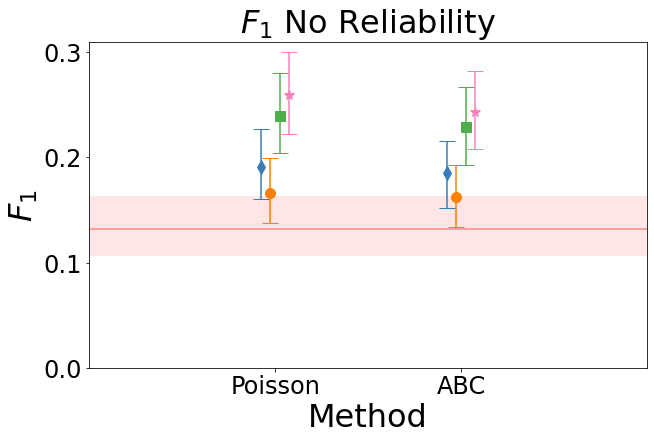

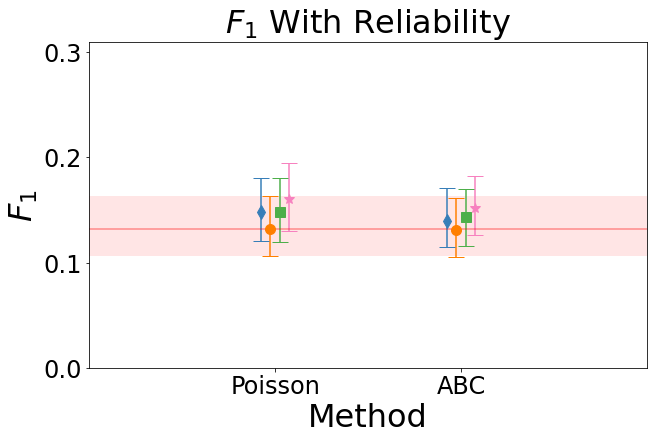

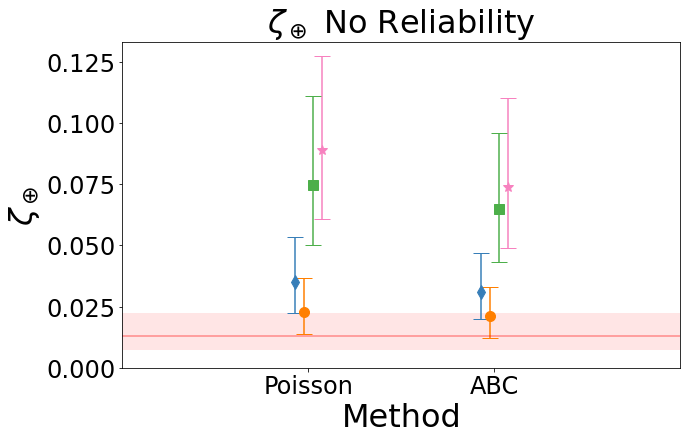

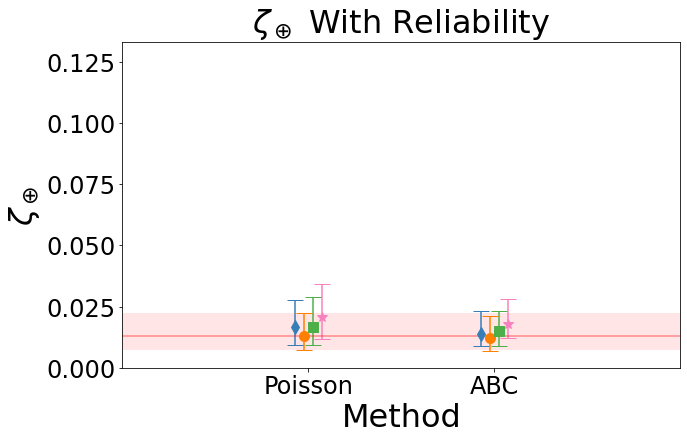

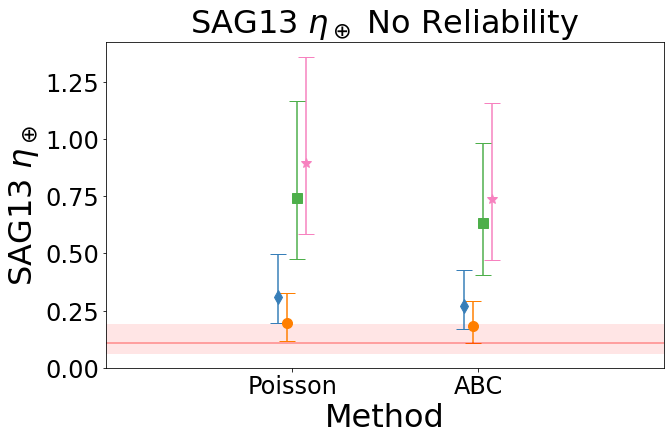

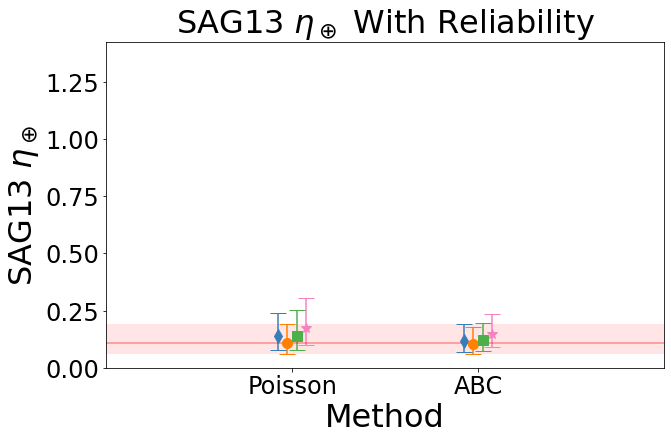

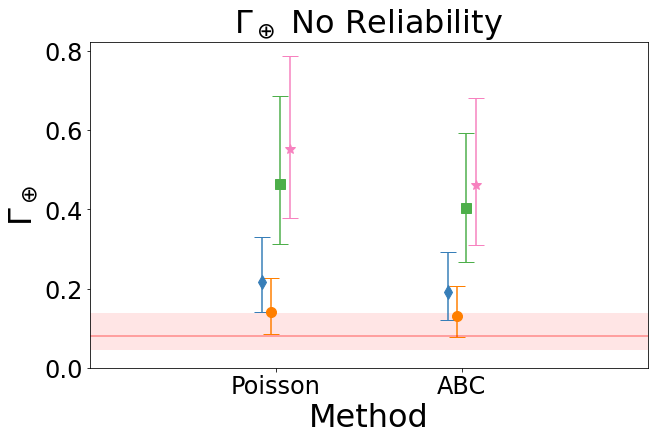

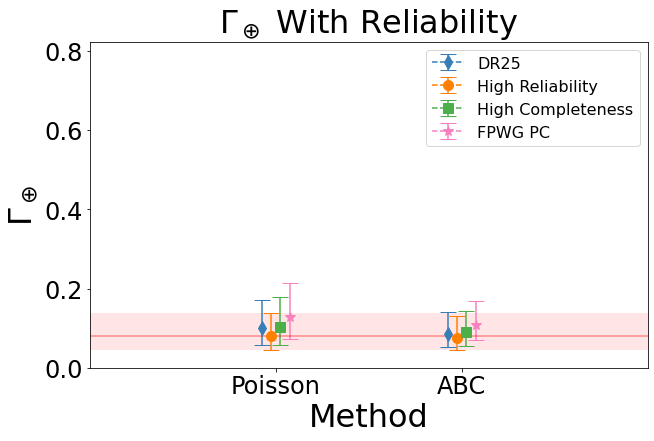

In [15]:
capsize = 8
xsize = 3
dx = 0.05
cbc = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
marker = ['d', 'o', 's', '*']

for ocIndex in range(len(ocNames)):
    fig,ax = plt.subplots(figsize=(10,6));

    for j in range(len(scNames)):
        for k in range(len(caseNamesNR)):
            plt.errorbar(j+1+(k-1.5)*dx, ocDataNR[ocIndex, j, k, 0], yerr=[[ocDataNR[ocIndex, j, k, 2]],[ocDataNR[ocIndex, j, k, 1]]], 
                         capsize = capsize, color = cbc[k], fmt='--'+marker[k], ms=10)
            
    plt.xticks([1, 2], ["Poisson", "ABC"])
#     if ocIndex == 0:
#         plt.legend(["DR25", "High Reliability", "High Completeness", "FPWG PC"], fontsize = 16)
    
    baselineZeta = ocDataWR[ocIndex, 0, 1, :];
    rect = patches.Rectangle((0,baselineZeta[0]-baselineZeta[2]), xsize, 
                         baselineZeta[1]+baselineZeta[2], facecolor = 'r', alpha = 0.1)
    plt.plot([0, xsize], [baselineZeta[0], baselineZeta[0]], 'r', alpha = 0.4)
    ax.add_patch(rect)
    plt.xlim(0,xsize)
    yl = plt.ylim();
    plt.ylim(0, yl[1]);
    plt.tick_params(labelsize = 24)
    plt.xlabel("Method", fontsize = 32)
    plt.ylabel(ocStr[ocIndex], fontsize = 32)
    plt.savefig(ocNames[ocIndex] + "ABCCompareNR.pdf",bbox_inches='tight')
    plt.title(ocStr[ocIndex] + " No Reliability", fontsize = 32)

    
    fig,ax = plt.subplots(figsize=(10,6));
    for j in range(len(scNames)):
        for k in range(0,len(caseNamesWR)):
            plt.errorbar(j+1+(k-1.5)*dx, ocDataWR[ocIndex, j, k, 0], yerr=[[ocDataWR[ocIndex, j, k, 2]],[ocDataWR[ocIndex, j, k, 1]]], 
                         capsize = capsize, color = cbc[k], fmt='--'+marker[k], ms=10)
    plt.xticks([1, 2], ["Poisson", "ABC"])
#     plt.legend(["DR25", "High Reliability", "High Completeness", "FPWG PC"], fontsize = 16)
    
    if ocIndex == 3:
        plt.legend(["DR25", "High Reliability", "High Completeness", "FPWG PC"], fontsize = 16)
    rect = patches.Rectangle((0,baselineZeta[0]-baselineZeta[2]), xsize, 
                         baselineZeta[1]+baselineZeta[2], facecolor = 'r', alpha = 0.1)
    plt.plot([0, xsize], [baselineZeta[0], baselineZeta[0]], 'r', alpha = 0.4)
    ax.add_patch(rect)
    plt.xlim(0,xsize)
    plt.ylim(0, yl[1])
    plt.tick_params(labelsize = 24)
    plt.xlabel("Method", fontsize = 32)
    plt.ylabel(ocStr[ocIndex], fontsize = 32)
    plt.savefig(ocNames[ocIndex] + "ABCCompareWR.pdf",bbox_inches='tight')
    plt.title(ocStr[ocIndex] + " With Reliability", fontsize = 32)


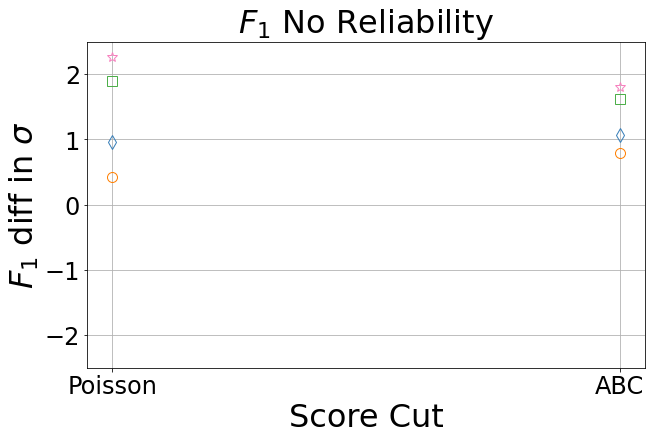

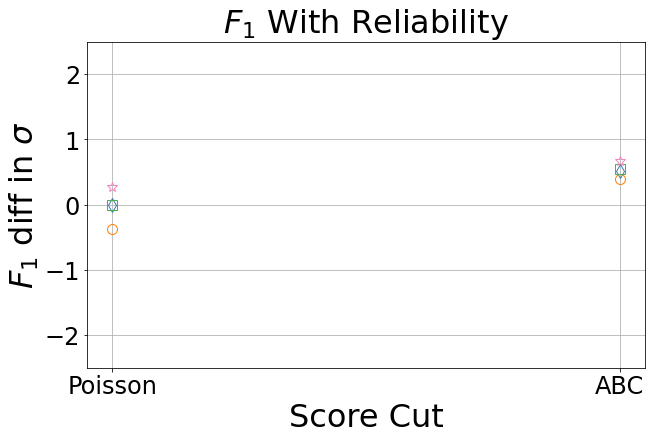

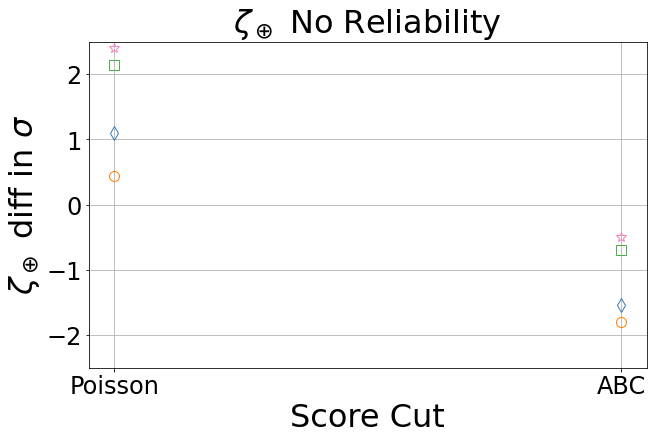

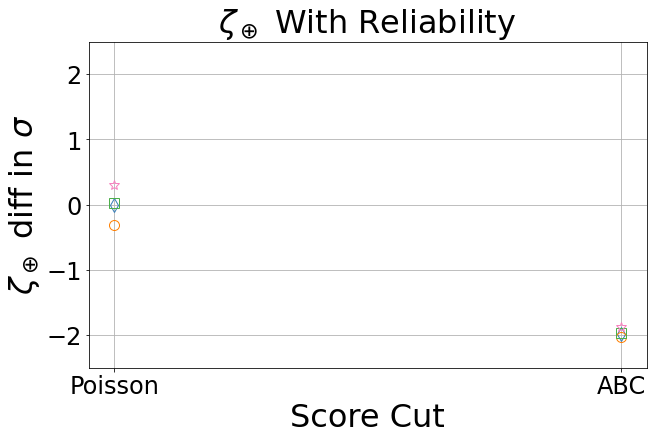

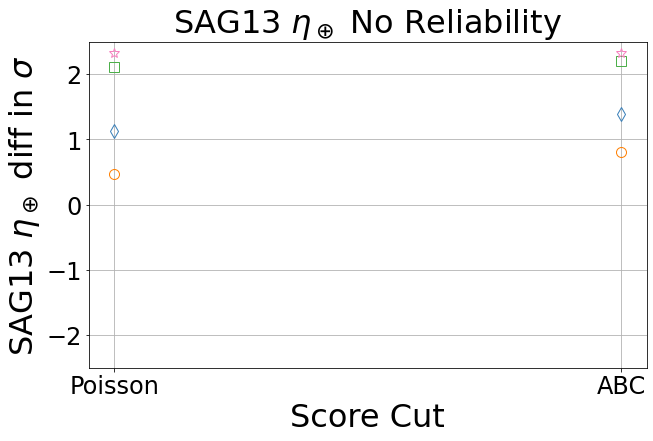

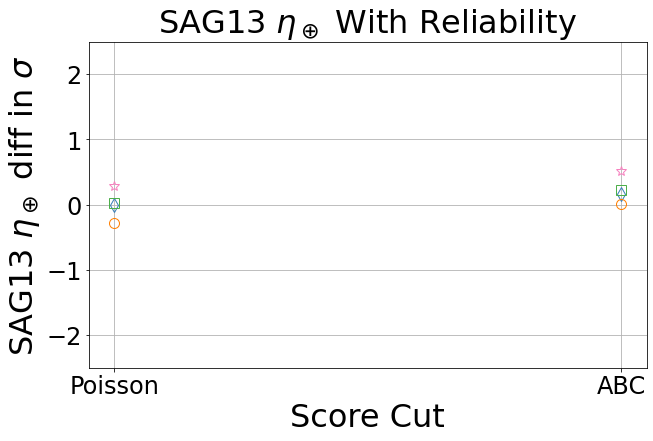

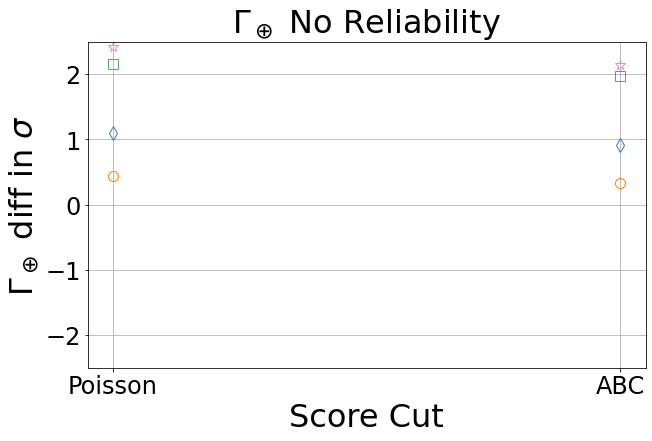

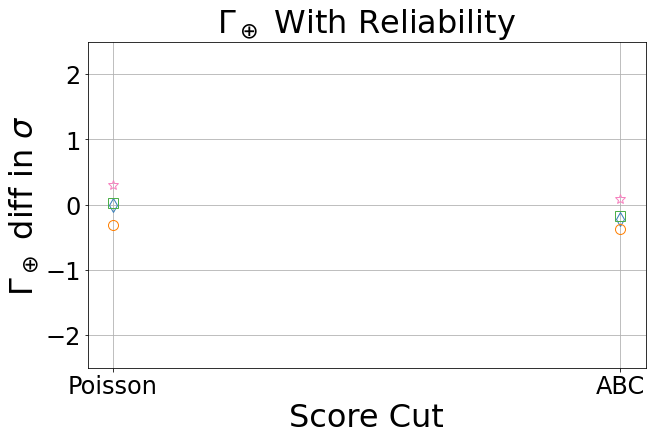

In [12]:
for ocIndex in range(len(ocNames)):
    fig,ax = plt.subplots(figsize=(10,6));

    for j in range(len(scNames)):
        for k in range(len(caseNamesNR)):
            plt.plot(j+1, ocDeltaNR[ocIndex, j, k, 2], marker[k], fillstyle="none", color = cbc[k], ms=10)
    plt.xticks([1, 2], ["Poisson", "ABC"])
#     if ocIndex == 0:
#         plt.legend(["DR25", "High Reliability", "High Completeness", "FPWG PC"], fontsize = 16)
    
    plt.ylim(-2.5,2.5)
    plt.tick_params(labelsize = 24)
    plt.xlabel("Score Cut", fontsize = 32)
    plt.ylabel(ocStr[ocIndex] + " diff in $\sigma$", fontsize = 32)
    plt.grid()
#     plt.savefig(ocNames[ocIndex] + "scCompareNRSigma.pdf",bbox_inches='tight')
    plt.title(ocStr[ocIndex] + " No Reliability", fontsize = 32)

    
    fig,ax = plt.subplots(figsize=(10,6));
    for j in range(len(scNames)):
        for k in range(len(caseNamesWR)):
            plt.plot(j+1, ocDeltaWR[ocIndex, j, k, 2], marker[k], fillstyle="none", color = cbc[k], ms=10)
    plt.xticks([1, 2], ["Poisson", "ABC"])
#     plt.legend(["DR25", "High Reliability", "High Completeness", "FPWG PC"], fontsize = 16)
    
    plt.ylim(-2.5,2.5)
    plt.tick_params(labelsize = 24)
    plt.xlabel("Score Cut", fontsize = 32)
    plt.ylabel(ocStr[ocIndex] + " diff in $\sigma$", fontsize = 32)
    plt.grid()
#     plt.savefig(ocNames[ocIndex] + "scCompareWRSigma.pdf",bbox_inches='tight')
    plt.title(ocStr[ocIndex] + " With Reliability", fontsize = 32)
